In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load the training data
train_data = pd.read_excel('/content/TrainingData.xlsx')

# Preprocess the data
def preprocess_data(data):
    # Normalize the capacity values
    scaler = MinMaxScaler()
    data['Capacity'] = scaler.fit_transform(data[['Capacity']])

    # Assign numeric IDs to Battery_ID
    data['Battery_ID'] = data.groupby('Battery_ID').ngroup()

    # Sort the data by Battery_ID and Cycle
    data = data.sort_values(['Battery_ID', 'Cycle'])

    return data, scaler

train_data, scaler = preprocess_data(train_data)


In [5]:
# Define the maximum sequence length
max_length = 495

# Reshape the data into sequences
def reshape_data(data, max_length):
    grouped = data.groupby('Battery_ID')
    sequences = []

    for _, group in grouped:
        seq = group[['Capacity']].values
        sequences.append(seq)

    return pad_sequences(sequences, maxlen=max_length, dtype='float32', padding='post', truncating='post')

X_train = reshape_data(train_data, max_length)
print(X_train.shape)

# Ensure X_train has the correct shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))


(6, 495, 1)


In [6]:
# Build the LSTM forecasting model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 254ms/step - loss: 0.3633 - val_loss: 0.4021
Epoch 3/50
1/1 [==============================] - 0s 261ms/step - loss: 0.3533 - val_loss: 0.3878
Epoch 4/50
1/1 [==============================] - 0s 277ms/step - loss: 0.3344 - val_loss: 0.3731
Epoch 5/50
1/1 [==============================] - 0s 262ms/step - loss: 0.3145 - val_loss: 0.3577
Epoch 6/50
1/1 [==============================] - 0s 261ms/step - loss: 0.2942 - val_loss: 0.3409
Epoch 7/50
1/1 [==============================] - 0s 250ms/step - loss: 0.2896 - val_loss: 0.3230
Epoch 8/50
1/1 [==============================] - 0s 276ms/step - loss: 0.2746 - val_loss: 0.3041
Epoch 9/50
1/1 [==============================] - 0s 264ms/step - loss: 0.2557 - val_loss: 0.2837
Epoch 10/50
1/1 [==============================] - 0s 246ms/step - loss: 0.2489 - val_loss: 0.2611
Epoch 11/50
1/1 [==============================] - 0s 255ms/step - loss: 0.2411 - val_loss: 0.2354
Epoch 12/50
1/1 [============

In [7]:
# Load the testing data
test_data = pd.read_excel('/content/TestingData.xlsx')
print(test_data.head(499))

# Preprocess the data
def preprocess_data(data):
    # Normalize the capacity values
    scaler = MinMaxScaler()
    data['Capacity'] = scaler.fit_transform(data[['Capacity']])

    # Assign numeric IDs to Battery_ID
    data['Battery_ID'] = data.groupby('Battery_ID').ngroup()

    # Sort the data by Battery_ID and Cycle
    data = data.sort_values(['Battery_ID', 'Cycle'])

    return data, scaler

test_data, scaler = preprocess_data(test_data)


# Define the maximum sequence length
max_length = 495

# Reshape the data into sequences
def reshape_data(data, max_length):
    grouped = data.groupby('Battery_ID')
    sequences = []

    for _, group in grouped:
        seq = group[['Capacity']].values
        sequences.append(seq)

    return pad_sequences(sequences, maxlen=max_length, dtype='float32', padding='post', truncating='post')

X_test = reshape_data(test_data, max_length)
print(X_test.shape)

# Ensure X_train has the correct shape
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

     Cycle Battery_ID  Capacity
0        1         B1  0.999216
1        2         B1  0.998092
2        3         B1  0.997206
3        4         B1  0.996253
4        5         B1  0.995537
..     ...        ...       ...
494    495         B1  0.640988
495    496         B1  0.639150
496    497         B1  0.627647
497    498         B1  0.623800
498    499         B1  0.620841

[499 rows x 3 columns]
(6, 495, 1)


In [16]:
# Make predictions
forecasts = model.predict(X_test)

# Inverse transform the predictions and the original data
forecasts_inverse = scaler.inverse_transform(forecasts.reshape(-1, 1)).reshape(forecasts.shape)
X_test_inverse = scaler.inverse_transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Calculate forecasting error
forecasting_error = np.abs(forecasts_inverse - X_test_inverse[:, -1, :])

# Set a threshold for anomaly detection
threshold = np.percentile(forecasting_error, 30)
print(f'Threshold: {threshold}')

# Detect anomalies
anomalies_test = (forecasting_error > threshold).astype(int)

# Calculate the number of anomalies in the testing data
num_anomalies_test = np.sum(anomalies_test)

print(f'forecasting_error: {forecasting_error}')
print(f'Number of Anomalies in Testing Data: {num_anomalies_test}')

1/1 [==============================] - 0s 81ms/step
Threshold: 0.07488369941711426
forecasting_error: [[0.09244668]
 [0.08376527]
 [0.07926798]
 [0.0758028 ]
 [0.0739646 ]
 [0.07290739]]
Number of Anomalies in Testing Data: 4


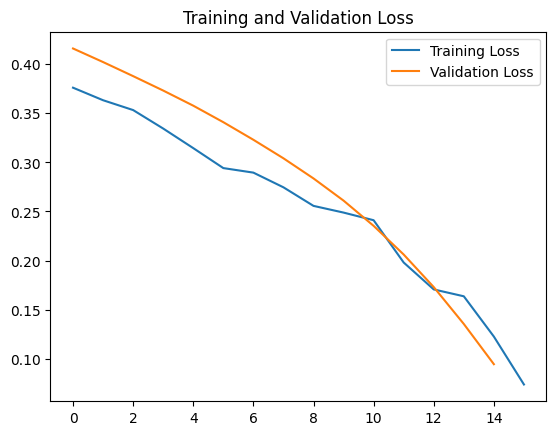

In [10]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

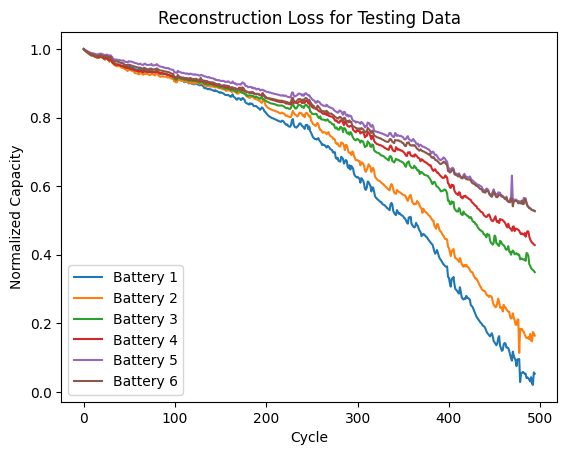

In [11]:
# Plot the reconstruction loss for all batteries in the testing data
for i in range(X_test.shape[0]):
    plt.plot(X_test[i, :, 0], label=f'Battery {i+1}')
plt.title('Reconstruction Loss for Testing Data')
plt.xlabel('Cycle')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.show()




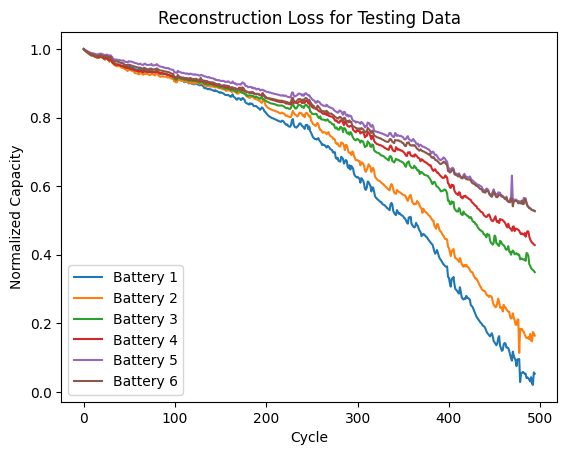

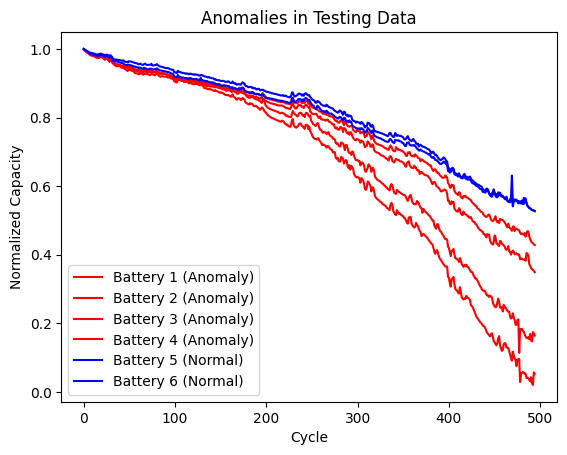

Cycles to Anomaly: [309, 332, 388, 402, -1, -1]


In [12]:
# Plot the reconstruction loss for all batteries in the testing data
for i in range(X_test.shape[0]):
    plt.plot(X_test[i, :, 0], label=f'Battery {i+1}')
plt.title('Reconstruction Loss for Testing Data')
plt.xlabel('Cycle')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.show()

# Plot the anomalies in the testing data
for i in range(X_test.shape[0]):
    if anomalies_test[i] == 1:
        plt.plot(X_test[i, :, 0], color='red', label=f'Battery {i+1} (Anomaly)')
    else:
        plt.plot(X_test[i, :, 0], color='blue', label=f'Battery {i+1} (Normal)')

plt.title('Anomalies in Testing Data')
plt.xlabel('Cycle')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.show()

# Calculate the number of cycles after which anomaly shows
cycles_to_anomaly = []
for i in range(X_test.shape[0]):
    if anomalies_test[i] == 1:
        anomaly_cycle = np.argmax(X_test[i, :, 0] < 0.6) + 1
        cycles_to_anomaly.append(anomaly_cycle)
    else:
        cycles_to_anomaly.append(-1)

print(f'Cycles to Anomaly: {cycles_to_anomaly}')

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Example anomalies_test, replace this with your actual data
#anomalies_test = [1, 1, 1, 1, 0, 0]

anomalies_array = np.array(anomalies_test)

# Print the first few elements of the anomalies array
print("Test anomalies:",anomalies_array)

# Actual anomalies
actual_anomalies = [1, 1, 1, 1, 0, 0]

# Convert actual_anomalies to a numpy array
actual_anomalies_array = np.array(actual_anomalies)



# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(actual_anomalies_array, anomalies_array)
precision = precision_score(actual_anomalies_array, anomalies_array)
recall = recall_score(actual_anomalies_array, anomalies_array)
f1 = f1_score(actual_anomalies_array, anomalies_array)

# Print the scores
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Test anomalies: [[1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
